In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
#from albumentations.pytorch import ToTensorV2
from tqdm import tqdm,trange
import torch.optim as optim
from numba import cuda
from torch.nn import functional as F 
import pandas as pd
!pip install --upgrade xlrd
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
print(DEVICE)
data_dir="/content/drive/MyDrive/Bengali-CFY/Bengali-CFY/data"
label_dir="/content/drive/MyDrive/Bengali-CFY/Bengali-CFY/labels.xls"

cuda


In [ ]:
class Devseg_data(Dataset):
    def __init__(self, data_dir,label_dir, transform = None):
        self.datapath=data_dir
        self.df=pd.read_excel(label_dir)
        self.transform=transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        self.image=self.transform(Image.open(self.datapath+'/'+self.df.iloc[index,0]+'.jpg'))
        self.label=torch.tensor(self.df.iloc[index,1])
        return self.image,self.label

In [ ]:
def get_loaders(
    image_dir,
    label_dir,
    batch_size,
    transform,
    num_workers = 0,
    pin_memory = True):

    dataset = Devseg_data(
        data_dir = data_dir,
        label_dir=label_dir,
        transform=transform)
    train_size = int(0.7*len(dataset))
    val_size=int(0.1*len(dataset))
    test_size=len(dataset)-train_size-val_size
    print(f"Train size = {train_size}")
    print(f"Val size = {val_size}")
    print(f"test_size={test_size}")
    train_ds, val_ds,test_ds = torch.utils.data.random_split(dataset,[train_size,val_size,test_size])
    train_loader = DataLoader(
            train_ds,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            shuffle = True)
    
    val_loader = DataLoader(
            val_ds,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            shuffle = False)
    test_loader = DataLoader(
            test_ds,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            shuffle = False)
    
    return dataset,train_loader, val_loader,test_loader

In [ ]:
BATCH_SIZE=10
NUM_WORKERS=0
PIN_MEMORY=True
transform=transforms.Compose([transforms.Resize(255),transforms.ToTensor()])
a,train_loader, val_loader,test_loader = get_loaders(
        data_dir,
        label_dir,
        BATCH_SIZE,
        transform,
        NUM_WORKERS,
        PIN_MEMORY)
type(train_loader)

Train size = 974
Val size = 139
test_size=279


torch.utils.data.dataloader.DataLoader

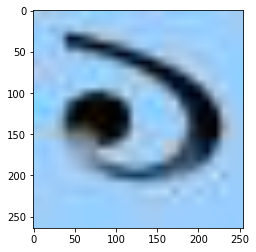

In [ ]:
m,n=a[5] 
#print(m.shape)
plt.imshow(m.T)

In [ ]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = self.fc_3(x)

        return x, h

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [ ]:
class VGG16_NET(nn.Module):
    def __init__(self):
        super(VGG16_NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(8192, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5) 
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)

        return x,x

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train_fn(loader,model,optimizer,criterion,):
  epoch_loss = 0
  epoch_acc = 0
  num_epochs=5
  model.train()
  for epoch in range(num_epochs):
    loop = tqdm(loader)
    for batch_idx, (x,y) in enumerate(loop):
          
          x=x.to(device=DEVICE)
          y=y.to(device=DEVICE)
          optimizer.zero_grad()
          y_pred,_=model(x)
          m=nn.LogSoftmax(dim=1)
          loss=criterion(m(y_pred),y)
          acc = calculate_accuracy(m(y_pred), y)
          loss.backward()

          optimizer.step()

          epoch_loss += loss.item()
          epoch_acc += acc.item()
          loop.set_postfix(loss=loss.item())
    return epoch_loss / len(loader), epoch_acc / len(loader)
    

In [ ]:
def evaluate(loader,model,criterion,):
  epoch_loss = 0
  epoch_acc = 0
  num_epochs=5
  model.eval()
  for epoch in range(num_epochs):
    loop = tqdm(loader)
    for batch_idx, (x,y) in enumerate(loop):
          
          x=x.to(device=DEVICE)
          y=y.to(device=DEVICE)
          y_pred,_=model(x)
          m=nn.LogSoftmax(dim=1)
          loss=criterion(m(y_pred),y)
          acc = calculate_accuracy(m(y_pred), y)
          epoch_loss += loss.item()
          epoch_acc += acc.item()
          loop.set_postfix(loss=loss.item())
    return epoch_loss / len(loader), epoch_acc / len(loader)
    

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def lenet():
  print("LENET implementation")
  transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])
  learning_rate = 0.001
  num_epochs = 7
  BATCH_SIZE=5
  NUM_WORKERS=0;
  PIN_MEMORY=False
  OUTPUT_DIM = 10
  model = LeNet(OUTPUT_DIM).cuda()
  model.train()
  criterion = nn.NLLLoss()
  model = model.to(DEVICE)
  criterion = criterion.to(DEVICE)
  best_valid_loss = float('inf')
  optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  a,train_loader, val_loader,test_loader = get_loaders(
        data_dir,
        label_dir,
        BATCH_SIZE,
        transform,
        NUM_WORKERS,
        PIN_MEMORY)

  for epoch in range(num_epochs):
    start_time = time.monotonic()
    train_loss, train_acc=train_fn(train_loader, model, optimizer,criterion)
    valid_loss, valid_acc =evaluate(val_loader,model,criterion)
    test_loss, test_acc = evaluate( test_loader,model,criterion)
  
    if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')



In [ ]:
def MLP_NET():
  print("MLP implementation")
  transform=transforms.Compose([transforms.Resize((16,26)),transforms.ToTensor()])
  learning_rate = 0.001
  num_epochs = 7
  BATCH_SIZE=5
  NUM_WORKERS=0;
  PIN_MEMORY=False
  OUTPUT_DIM = 10
  INPUT_DIM=3*16*26
  model = MLP(INPUT_DIM,OUTPUT_DIM).cuda()
  model.train()
  criterion = nn.NLLLoss()
  model = model.to(DEVICE)
  criterion = criterion.to(DEVICE)
  best_valid_loss = float('inf')
  optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  a,train_loader, val_loader,test_loader = get_loaders(
        data_dir,
        label_dir,
        BATCH_SIZE,
        transform,
        NUM_WORKERS,
        PIN_MEMORY)

  for epoch in range(num_epochs):
    start_time = time.monotonic()
    train_loss, train_acc=train_fn(train_loader, model, optimizer,criterion)
    valid_loss, valid_acc =evaluate(val_loader,model,criterion)
    test_loss, test_acc = evaluate( test_loader,model,criterion)
  
    if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')




In [ ]:
def alexnet_NET():
  print("alexnet implementation")
  transform=transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])
  learning_rate = 0.001
  num_epochs = 7
  BATCH_SIZE=5
  NUM_WORKERS=0;
  PIN_MEMORY=False
  OUTPUT_DIM=10
  model=AlexNet(OUTPUT_DIM)
  model.train()
  criterion = nn.NLLLoss()
  model = model.to(DEVICE)
  criterion = criterion.to(DEVICE)
  best_valid_loss = float('inf')
  optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  a,train_loader, val_loader,test_loader = get_loaders(
        data_dir,
        label_dir,
        BATCH_SIZE,
        transform,
        NUM_WORKERS,
        PIN_MEMORY)

  for epoch in range(num_epochs):
    start_time = time.monotonic()
    train_loss, train_acc=train_fn(train_loader, model, optimizer,criterion)
    valid_loss, valid_acc =evaluate(val_loader,model,criterion)
    test_loss, test_acc = evaluate( test_loader,model,criterion)
  
    if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')




In [ ]:
def vggnet_NET():
  print("vggnet-implementation")
  transform=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
  learning_rate = 0.001
  num_epochs = 7
  BATCH_SIZE=5
  NUM_WORKERS=0;
  PIN_MEMORY=False
  model=VGG16_NET()
  model.train()
  criterion = nn.NLLLoss()
  model = model.to(DEVICE)
  criterion = criterion.to(DEVICE)
  best_valid_loss = float('inf')
  optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  a,train_loader, val_loader,test_loader = get_loaders(
        data_dir,
        label_dir,
        BATCH_SIZE,
        transform,
        NUM_WORKERS,
        PIN_MEMORY)

  for epoch in range(num_epochs):
    start_time = time.monotonic()
    train_loss, train_acc=train_fn(train_loader, model, optimizer,criterion)
    valid_loss, valid_acc =evaluate(val_loader,model,criterion)
    test_loss, test_acc = evaluate( test_loader,model,criterion)
  
    if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')




In [ ]:
def main():
  model1=vggnet_NET()
  model2=alexnet_NET()
  model3=MLP_NET()
  model4 = lenet()
  
  
  


In [ ]:
if __name__ == "__main__":
    main() 

vggnet-implementation
Train size = 974
Val size = 139
test_size=279


100%|██████████| 56/56 [00:01<00:00, 28.96it/s, loss=2.2]


Epoch: 01 | Epoch Time: 0m 17s
	Train Loss: 2.244 | Train Acc: 17.97%
	 Val. Loss: 2.186 |  Val. Acc: 22.32%
Test Loss: 2.266 | Test Acc: 18.66%


100%|██████████| 56/56 [00:01<00:00, 43.84it/s, loss=2.18]


Epoch: 02 | Epoch Time: 0m 16s
	Train Loss: 2.229 | Train Acc: 19.90%
	 Val. Loss: 2.210 |  Val. Acc: 23.04%
Test Loss: 2.267 | Test Acc: 18.66%


100%|██████████| 56/56 [00:01<00:00, 42.83it/s, loss=2.08]


Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 2.227 | Train Acc: 20.10%
	 Val. Loss: 2.205 |  Val. Acc: 22.32%
Test Loss: 2.271 | Test Acc: 18.66%


100%|██████████| 56/56 [00:01<00:00, 42.79it/s, loss=2.13]


Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 2.220 | Train Acc: 20.31%
	 Val. Loss: 2.200 |  Val. Acc: 22.32%
Test Loss: 2.263 | Test Acc: 18.66%


100%|██████████| 56/56 [00:01<00:00, 43.65it/s, loss=2.15]


Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 2.226 | Train Acc: 20.33%
	 Val. Loss: 2.186 |  Val. Acc: 22.32%
Test Loss: 2.257 | Test Acc: 18.66%


100%|██████████| 56/56 [00:01<00:00, 43.53it/s, loss=2.13]


Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 2.215 | Train Acc: 20.38%
	 Val. Loss: 2.213 |  Val. Acc: 22.32%
Test Loss: 2.260 | Test Acc: 18.66%


100%|██████████| 56/56 [00:01<00:00, 43.68it/s, loss=2.17]


Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 2.221 | Train Acc: 20.44%
	 Val. Loss: 2.209 |  Val. Acc: 22.32%
Test Loss: 2.260 | Test Acc: 18.66%
alexnet implementation
Train size = 974
Val size = 139
test_size=279


100%|██████████| 56/56 [00:00<00:00, 80.34it/s, loss=2.24]


Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 2.249 | Train Acc: 19.15%
	 Val. Loss: 2.252 |  Val. Acc: 19.29%
Test Loss: 2.272 | Test Acc: 19.02%


100%|██████████| 56/56 [00:00<00:00, 80.25it/s, loss=2.04]


Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 2.241 | Train Acc: 19.13%
	 Val. Loss: 2.172 |  Val. Acc: 19.64%
Test Loss: 2.266 | Test Acc: 15.80%


100%|██████████| 56/56 [00:00<00:00, 81.21it/s, loss=2.17]


Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 2.233 | Train Acc: 19.13%
	 Val. Loss: 2.189 |  Val. Acc: 19.29%
Test Loss: 2.246 | Test Acc: 19.02%


100%|██████████| 56/56 [00:00<00:00, 78.53it/s, loss=2.14]


Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 2.233 | Train Acc: 19.59%
	 Val. Loss: 2.200 |  Val. Acc: 19.29%
Test Loss: 2.244 | Test Acc: 19.02%


100%|██████████| 56/56 [00:00<00:00, 75.83it/s, loss=2.18]


Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 2.228 | Train Acc: 20.64%
	 Val. Loss: 2.211 |  Val. Acc: 19.29%
Test Loss: 2.249 | Test Acc: 19.02%


100%|██████████| 56/56 [00:00<00:00, 78.47it/s, loss=2.17]


Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 2.225 | Train Acc: 20.62%
	 Val. Loss: 2.207 |  Val. Acc: 19.29%
Test Loss: 2.253 | Test Acc: 19.02%


100%|██████████| 56/56 [00:00<00:00, 77.07it/s, loss=2.15]


Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 2.227 | Train Acc: 20.62%
	 Val. Loss: 2.184 |  Val. Acc: 19.29%
Test Loss: 2.248 | Test Acc: 19.02%
MLP implementation
Train size = 974
Val size = 139
test_size=279


100%|██████████| 56/56 [00:00<00:00, 83.85it/s, loss=1.55]


Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 2.213 | Train Acc: 17.97%
	 Val. Loss: 2.032 |  Val. Acc: 26.43%
Test Loss: 2.112 | Test Acc: 23.75%


100%|██████████| 56/56 [00:00<00:00, 85.25it/s, loss=0.89]


Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 1.958 | Train Acc: 30.51%
	 Val. Loss: 1.737 |  Val. Acc: 44.46%
Test Loss: 1.829 | Test Acc: 38.21%


100%|██████████| 56/56 [00:00<00:00, 85.43it/s, loss=0.733]


Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 1.662 | Train Acc: 44.51%
	 Val. Loss: 1.446 |  Val. Acc: 53.21%
Test Loss: 1.547 | Test Acc: 51.07%


100%|██████████| 56/56 [00:00<00:00, 85.49it/s, loss=1.17]


Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 1.422 | Train Acc: 51.79%
	 Val. Loss: 1.343 |  Val. Acc: 58.21%
Test Loss: 1.394 | Test Acc: 56.25%


100%|██████████| 56/56 [00:00<00:00, 82.78it/s, loss=0.997]


Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 1.288 | Train Acc: 57.21%
	 Val. Loss: 1.350 |  Val. Acc: 59.46%
Test Loss: 1.416 | Test Acc: 54.20%


100%|██████████| 56/56 [00:00<00:00, 85.29it/s, loss=0.935]


Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 1.130 | Train Acc: 62.36%
	 Val. Loss: 1.212 |  Val. Acc: 61.79%
Test Loss: 1.231 | Test Acc: 58.48%


100%|██████████| 56/56 [00:00<00:00, 83.52it/s, loss=0.603]


Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 1.032 | Train Acc: 64.90%
	 Val. Loss: 1.241 |  Val. Acc: 57.32%
Test Loss: 1.255 | Test Acc: 58.13%
LENET implementation
Train size = 974
Val size = 139
test_size=279


100%|██████████| 56/56 [00:00<00:00, 80.76it/s, loss=1.85]


Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 2.205 | Train Acc: 20.10%
	 Val. Loss: 1.927 |  Val. Acc: 29.46%
Test Loss: 2.006 | Test Acc: 26.88%


100%|██████████| 56/56 [00:00<00:00, 80.37it/s, loss=0.501]


Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 1.543 | Train Acc: 47.90%
	 Val. Loss: 0.924 |  Val. Acc: 72.14%
Test Loss: 1.010 | Test Acc: 69.91%


100%|██████████| 56/56 [00:00<00:00, 79.62it/s, loss=0.572]


Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.746 | Train Acc: 76.90%
	 Val. Loss: 0.634 |  Val. Acc: 77.86%
Test Loss: 0.589 | Test Acc: 79.55%


100%|██████████| 56/56 [00:00<00:00, 80.16it/s, loss=0.713]


Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.483 | Train Acc: 84.00%
	 Val. Loss: 0.658 |  Val. Acc: 84.29%
Test Loss: 0.641 | Test Acc: 78.13%


100%|██████████| 56/56 [00:00<00:00, 81.76it/s, loss=0.424]


Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.347 | Train Acc: 89.23%
	 Val. Loss: 0.344 |  Val. Acc: 90.00%
Test Loss: 0.427 | Test Acc: 86.34%


100%|██████████| 56/56 [00:00<00:00, 73.45it/s, loss=0.204]


Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.268 | Train Acc: 90.87%
	 Val. Loss: 0.367 |  Val. Acc: 93.57%
Test Loss: 0.387 | Test Acc: 87.77%


100%|██████████| 56/56 [00:00<00:00, 81.10it/s, loss=0.185]

Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.185 | Train Acc: 94.05%
	 Val. Loss: 0.370 |  Val. Acc: 92.86%
Test Loss: 0.381 | Test Acc: 90.63%


In vgg loss tooks more time to converge minima rather than other models.
As compare to MLP architecture we got more accuracy in lenet for same learning rate and number of epochs.
